# Generative Adversarial Networks(GAN) (34%)

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args([])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(in_feat, out_feat, normalize=True):
        layers = [nn.Linear(in_feat, out_feat)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_feat, 0.8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    self.model = nn.Sequential(
        *block(opt.latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, int(np.prod(img_shape))),
        nn.Tanh()
    )

  def forward(self, z):
      img = self.model(z)
      img = img.view(img.size(0), *img_shape)
      return img


class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()

      self.model = nn.Sequential(
          nn.Linear(int(np.prod(img_shape)), 512),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(512, 256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(256, 1),
          nn.Sigmoid(),
      )

  def forward(self, img):
      img_flat = img.view(img.size(0), -1)
      validity = self.model(img_flat)

      return validity

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=20, sample_interval=400)


## a) Implement a GAN and train it on the MNIST dataset

In [2]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.MNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=opt.batch_size,
  shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    # Adversarial ground truths
    valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

    # Configure input
    real_imgs = Variable(imgs.type(Tensor))

    # -----------------
    #  Train Generator
    # -----------------

    optimizer_G.zero_grad()

    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

    # Generate a batch of images
    gen_imgs = generator(z)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)

    g_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
    )

    batches_done = epoch * len(dataloader) + i
    if batches_done % opt.sample_interval == 0:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


流式输出内容被截断，只能显示最后 5000 行内容。
[Epoch 14/20] [Batch 628/938] [D loss: 0.330018] [G loss: 5.302085]
[Epoch 14/20] [Batch 629/938] [D loss: 0.145213] [G loss: 2.572602]
[Epoch 14/20] [Batch 630/938] [D loss: 0.132315] [G loss: 2.342512]
[Epoch 14/20] [Batch 631/938] [D loss: 0.269108] [G loss: 3.059987]
[Epoch 14/20] [Batch 632/938] [D loss: 0.273628] [G loss: 1.222338]
[Epoch 14/20] [Batch 633/938] [D loss: 0.795943] [G loss: 6.771083]
[Epoch 14/20] [Batch 634/938] [D loss: 0.200316] [G loss: 1.556534]
[Epoch 14/20] [Batch 635/938] [D loss: 0.166722] [G loss: 3.793216]
[Epoch 14/20] [Batch 636/938] [D loss: 0.111562] [G loss: 2.956919]
[Epoch 14/20] [Batch 637/938] [D loss: 0.204445] [G loss: 2.053094]
[Epoch 14/20] [Batch 638/938] [D loss: 0.227894] [G loss: 3.275536]
[Epoch 14/20] [Batch 639/938] [D loss: 0.270761] [G loss: 1.120356]
[Epoch 14/20] [Batch 640/938] [D loss: 0.576243] [G loss: 6.194497]
[Epoch 14/20] [Batch 641/938] [D loss: 0.290377] [G loss: 1.358891]
[Epoch 14/20] [Batch 

In [3]:
def show_image(reconsPath):
  Image = mpimg.imread(reconsPath)
  plt.imshow(Image) 
  plt.axis('off') 
  plt.show()

## b) Plot 10 samples generated using the GAN
To reduce the training time, we set the #epcoh = 20, so the images are a little blury.

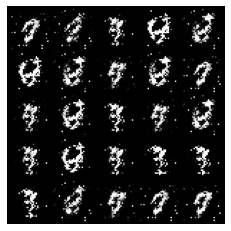

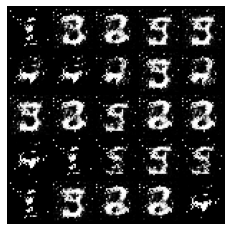

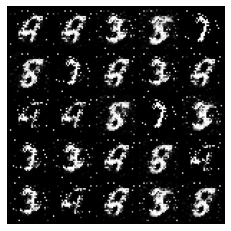

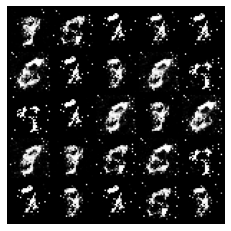

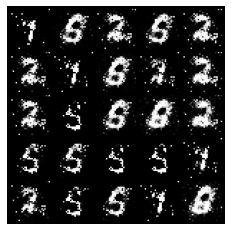

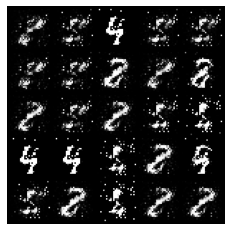

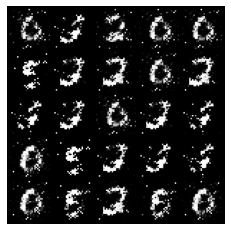

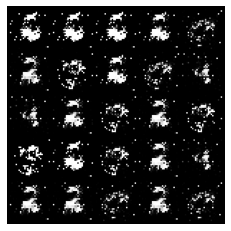

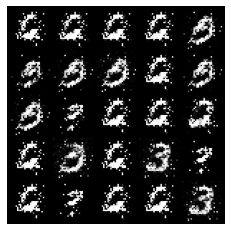

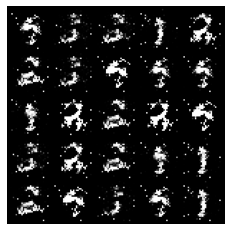

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

for i in range(14000, 18000, 400):
  reconsPath = './images/%d.png' %i
  show_image(reconsPath)